In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import scipy
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

### utils

In [2]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

What type of improvements should we expect when including supplemental locations in the QMD workflow?
Do these improvements depend on the season or geography?

1. Decrease in bias
2. Increase in scores (Brier, Equitable Threat)
3. Errors (MAE, RMSE)

# Bias

In [3]:
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]


files=sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_baselines/*/bias*_with_sl_CONUS_24h.zarr"), key=natsort)

In [4]:
no_sl = xr.open_mfdataset(sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_baselines/climo/bias*_without_sl_CONUS_24h.zarr"), key=natsort),
                         combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

climo = xr.open_mfdataset(files[:4], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')
facets = xr.open_mfdataset(files[4:8], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')
terrain = xr.open_mfdataset(files[8:], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

#f = files=sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/bias*_with_sl_CONUS_24h.zarr"), key=natsort)

#optimized = xr.open_mfdataset(f, combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

In [5]:
f = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/raw_GEFs/*.zarr"))

raw = xr.open_mfdataset(f, combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

In [7]:
models = [raw, no_sl, climo, terrain, facets]
months = [1,4,7,11]
model_names = ['Raw GEFs', 'No SL', 'Climo', 'Terrain', 'Facets']

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Bias [mm]')

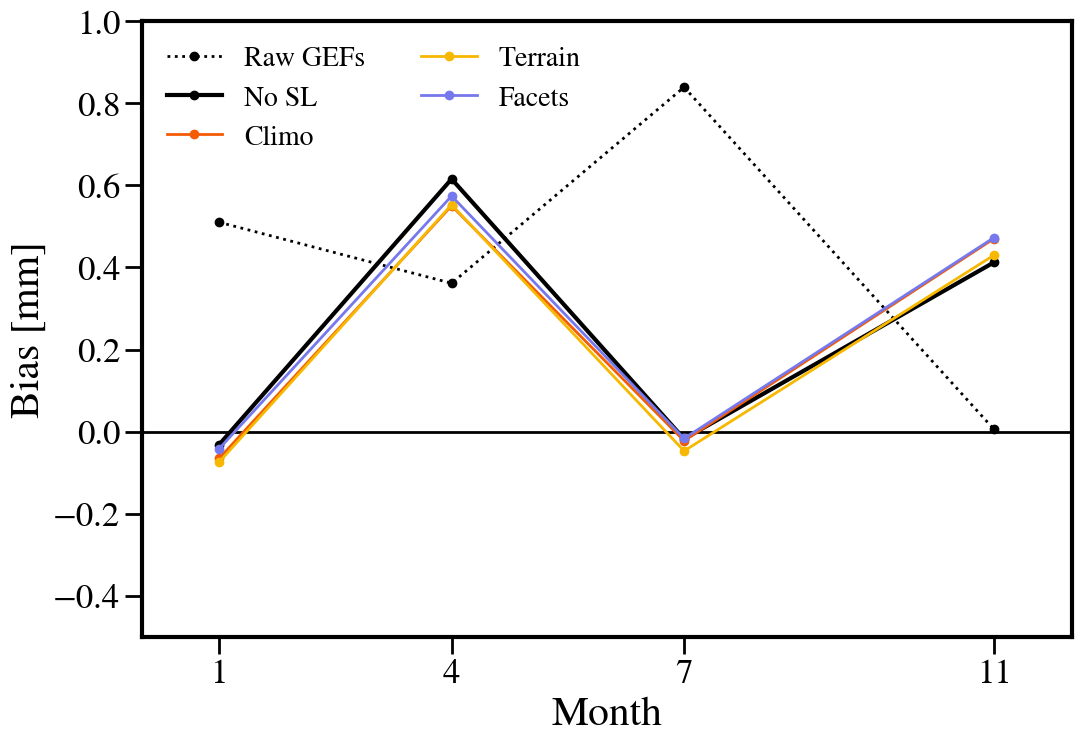

In [12]:
fig, axes = plt.subplots(1,1, sharex=True,sharey=True, figsize=(12, 8))
plt.subplots_adjust(wspace=0.1)
axes.set_ylim([-0.5, 1])
axes.set_xlim([0,12])

coolors = ['black', 'black', '#f35b04', '#f7b801', '#7678ed', '#3d348b']

model_means = np.zeros((3, 4))

for model in tqdm(range(len(models))):
    dat = models[model].bias.mean(dim='day').mean(dim='member').data.compute()
    mn , gp = np.where(np.isfinite(dat) == False)
    dat[mn,gp] = np.nan
    dat = np.nanmean(dat, axis=1)
    if model in [2, 3, 4]:
        model_means[model-2] = dat
    #err = models[model].bias.std(dim='day').std(dim='grid_point').std(dim='locations').data
    if model == 0: #no SLs
        #dat = models[model].bias.mean(dim='day').mean(dim='grid_point').data
        axes.plot(months, dat, lw=2, marker='o', ls=':',color=coolors[model],label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
        #axes[1].plot(months, dat, lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
    elif model == 1:
        axes.plot(months, dat, color=coolors[model], lw=3,marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#43BCCD', ls='None')
    elif model == 2:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#662E9B', ls='None')
    elif model == 3:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#EA3546', ls='None')
    elif model == 4:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[1].plot(months, dat, color='#F86624', lw=1.5, marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#F86624', ls='None')
    elif model == 5:
        axes.plot(months, dat, color=coolors[model], lw=2, ls='--',marker='o',label=model_names[model])
        #axes.errorbar(months, dat, yerr=err, color='#F9C80E', ls='None')

#for a in range(2):
axes.plot([0,12], [0,0], color='black', zorder=0, lw=2)
axes.legend(frameon=False, loc='upper left', ncol=2)
axes.set_xticks(months)
axes.set_xlabel('Month')

axes.set_ylabel('Bias [mm]')

In [13]:
model_means

array([[-0.06530155,  0.55008084, -0.02221368,  0.47029598],
       [-0.07403552,  0.55261633, -0.04703332,  0.4299849 ],
       [-0.0416268 ,  0.57382599, -0.01661717,  0.47270984]])

### coefficients

In [23]:
bias_to_coeff = np.zeros((3,4))

for month in range(len(months)):
    this_month_bias = model_means[:,month]
    b2c = 1. - np.abs(this_month_bias)
    bias_to_coeff[:,month] = b2c / np.max(b2c)

In [24]:
bias_to_coeff

array([[0.97529694, 1.        , 0.99430893, 0.92928068],
       [0.96618362, 0.99436456, 0.96906988, 1.        ],
       [1.        , 0.94722352, 1.        , 0.92504595]])

In [25]:
gefs_res = 0.25 #deg
conus_res = 2.5 #km

deg_per_km = 1. / 111.

gefs_res / deg_per_km

27.75

In [27]:
gefs_ratio = (gefs_res / deg_per_km) / conus_res
print(gefs_ratio)

11.1


Text(131.79166666666669, 0.5, 'Bias [mm]')

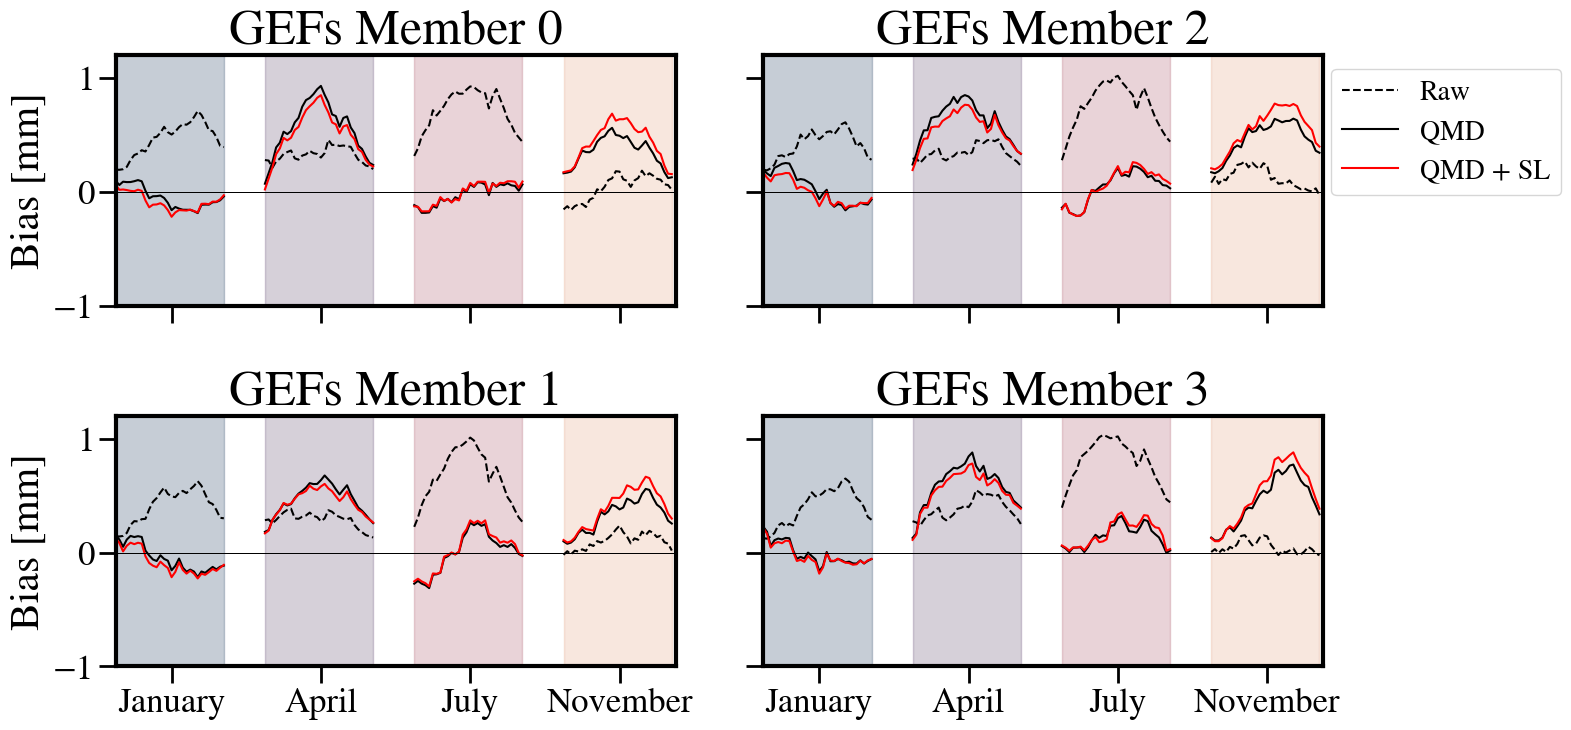

In [13]:
fig, axes = plt.subplots(2,2,sharex=True, sharey=True, figsize=(16,8))
coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']
lss = ['--', '-',  '-']

mn_colors = ['#355070', '#6d597a', '#b56576', '#eaac8b']
coolors = ['black', 'black', 'red']

axes[0,0].set_ylim([-1, 1.2])
axes[0,0].set_xlim([0,150])

N = 15

for i in range(2):
    for j in range(2):
        mem = i + 2*j
        for model in range(3):
            dat = models[model].bias.mean(dim='grid_point').data.compute()
            mn, day, mm = np.where(np.isfinite(dat) == False)
            dat[mn,day,mm] = np.nan
            for mn in range(0,4):
                doy1 = mn*40
                doy2 = doy1 + 30
                this_mem = np.ravel(dat[mn,:,mem])
                if (i == 0) and (j==1) and (mn == 0):
                    axes[i,j].plot(np.arange(doy1, doy2), np.convolve(this_mem, np.ones(N)/N, mode='same'), color=coolors[model], ls=lss[model],label=f"{model_names[model]}")
                else:
                    axes[i,j].plot(np.arange(doy1, doy2), np.convolve(this_mem, np.ones(N)/N, mode='same'), color=coolors[model], ls=lss[model])
                axes[i,j].fill_between(np.arange(doy1, doy2), -5, 5, color=mn_colors[mn], alpha=0.1)
                axes[i,j].plot([0,180],[0,0], color='black', lw=0.5)
        axes[i,j].set_title(f"GEFs Member {mem}")

axes[0,1].legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.tight_layout()
axes[1,0].set_xticks([15, 55, 95, 135])
axes[1,0].set_xticklabels(["January", 'April', 'July', 'November'])

axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')

In [69]:
gps = np.random.randint(10,2200, size=9)

In [1]:
gps = [713, 1239, 1913, 1009, 2022, 943, 700, 487, 778]

In [22]:
np.shape(dat)

(4, 2260)

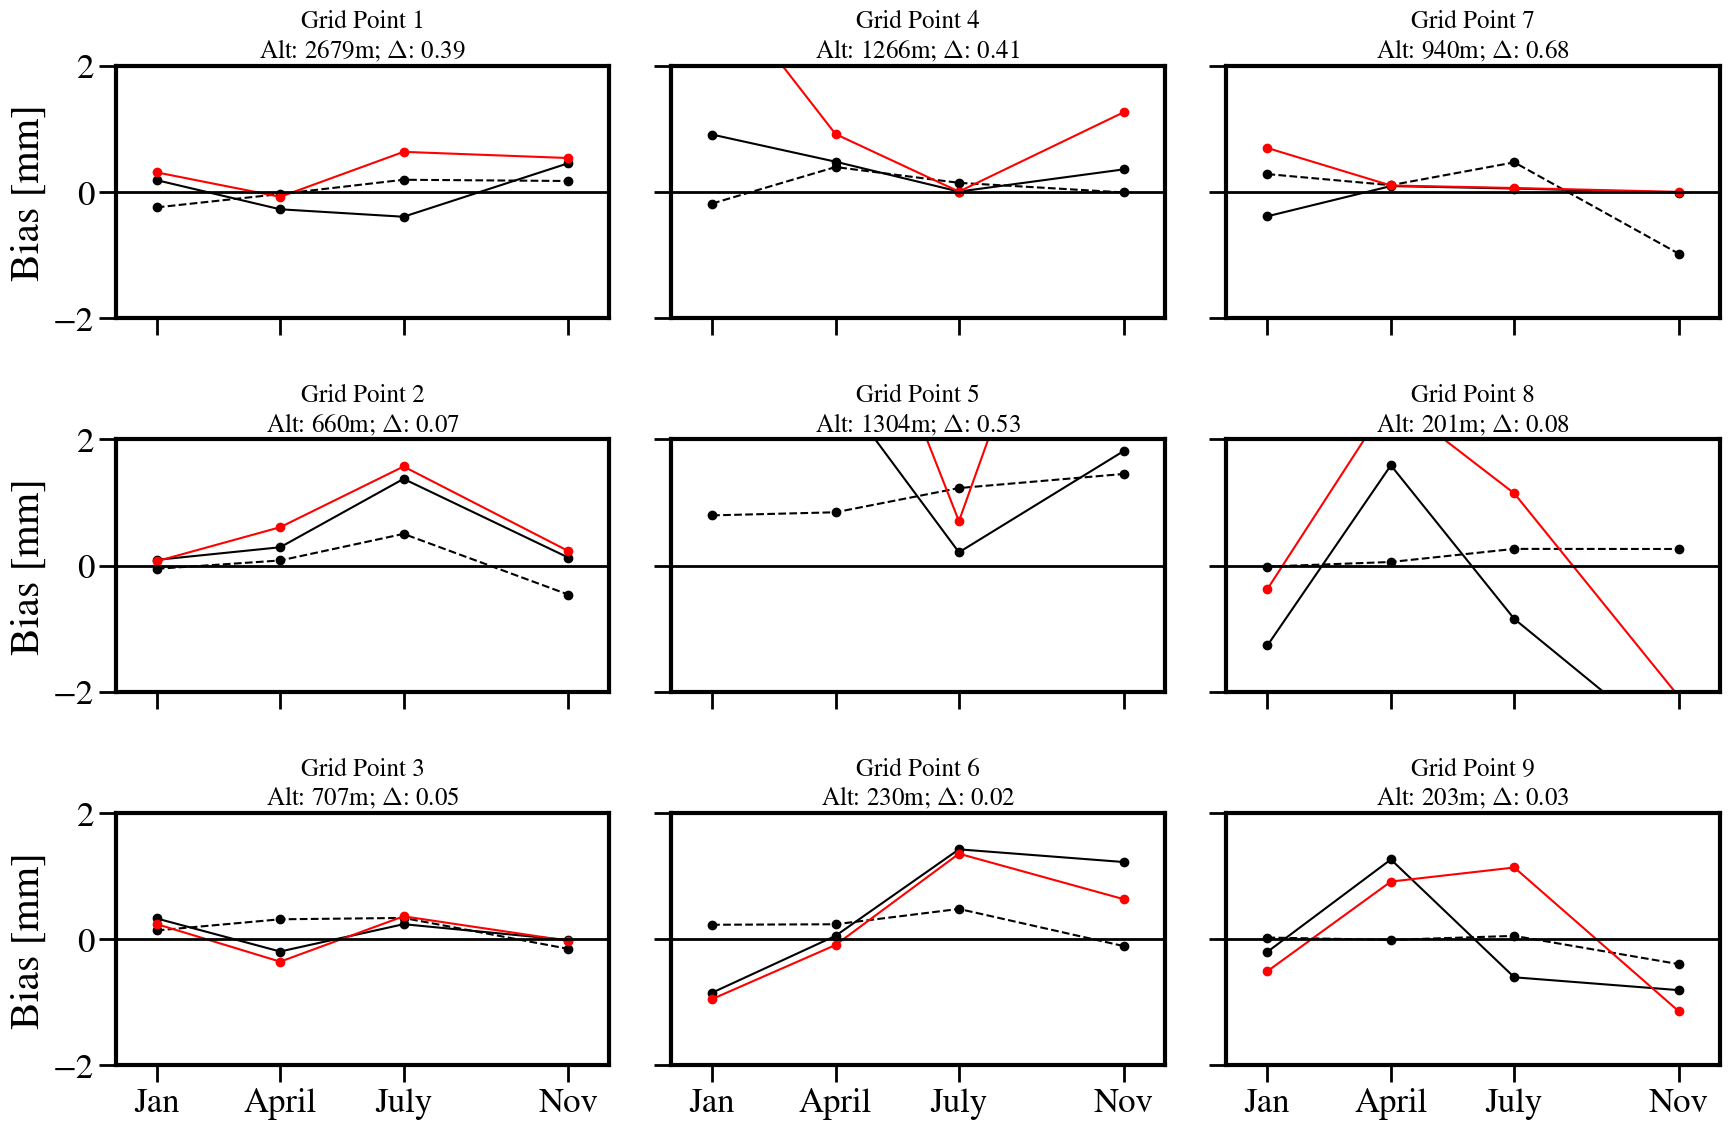

In [26]:
fig, axes = plt.subplots(3,3,sharex=True, sharey=True, figsize=(18,12))
coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']
lss = ['--', '-',  '-']

mn_colors = ['#355070', '#6d597a', '#b56576', '#eaac8b']

ccs = ['black', 'black', 'red']

axes[0,0].set_ylim([-2, 2])
axes[0,0].set_xlim([0,12])

N = 15

sc_tg = tg/np.max(tg)

for i in range(3):
    for j in range(3):
        g = gps[i+3*j]
        for model in range(3):
            dat = models[model].bias.mean(dim='member').mean(dim='day').data.compute()
            #mn, gp = np.where(np.isfinite(dat) == False)
            #dat[mn,day,gp] = np.nan
            if (i == 0) and (j==2):
                axes[i,j].plot(months, dat[:,g], marker='o',color=ccs[model], ls=lss[model])
            else:
                axes[i,j].plot(months, dat[:,g], marker='o',color=ccs[model], ls=lss[model])
            #axes[i,j].fill_between(np.arange(doy1, doy2), -5, 5, color=mn_colors[mn], alpha=0.1)
        axes[i,j].set_title(f"Grid Point {i+3*j+1}\nAlt: {np.int32(terrain[lat_idx[g], lon_idx[g]])}m; $\Delta$: {sc_tg[g]:.2f}", fontsize=18)
        axes[i,j].plot([-5,165], [0,0], color='black', lw=2)

#axes[0,2].legend(loc='upper right', bbox_to_anchor=(1.45, 1))
axes[1,0].set_xticks([1, 4, 7, 11])
axes[1,0].set_xticklabels(["Jan", 'April', 'July', 'Nov'])

axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')
axes[2,0].set_ylabel('Bias [mm]')
plt.tight_layout()

In [27]:
import matplotlib.patheffects as pe

{230.0: ([<matplotlib.lines.Line2D at 0x14d5a9f488b0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14d5a9f48c70>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14d5a9f49960>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14d5a9f499c0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14d5a9f498d0>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14d5a9f495d0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14d5a9f49420>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14d5a9f482b0>], [])}

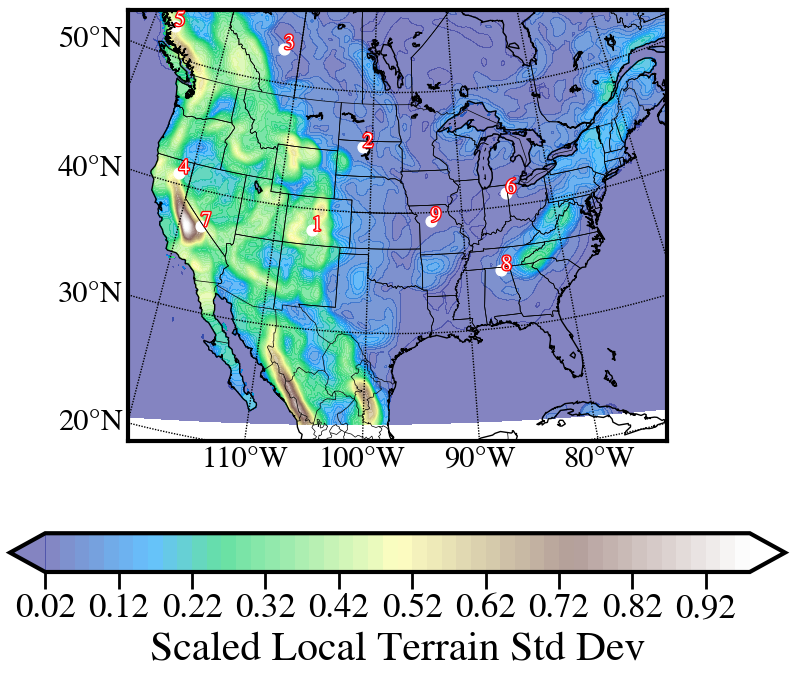

In [28]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

clevs_precip = [0.0,0.25,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12., 15., 20., 25.]

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')

x, y = m(lon_arr, lat_arr)  # transform coordinates
sc=m.contourf(x, y, terrain_std/np.max(terrain_std),levels=50,alpha=0.6,cmap='terrain',extend='both')
cbar=plt.colorbar(sc, location='bottom')
cbar.set_label("Scaled Local Terrain Std Dev")

scx, scy = m(lon_arr[lat_idx[gps], lon_idx[gps]], lat_arr[lat_idx[gps], lon_idx[gps]])
plt.scatter(scx, scy, s=60, color='white')
for i in range(9):
    plt.annotate(f"{i+1}", xy=(scx[i], scy[i]), fontsize=15, color='white', path_effects=[pe.withStroke(linewidth=2, foreground="red")])

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

#plt.title(f"GEFS 24h Precip {gday}\nvalid {vday}", fontsize=20)

In [100]:
consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')
conus_gp = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc')

In [105]:
consts.xa.size

2345

In [49]:
terrain_heights = consts.terrain.data
lats = consts.latitude.data
lons = consts.longitude.data

In [24]:
lat_idx = conus_gp.latitude_idx.data
lon_idx = conus_gp.longitude_idx.data

Text(0.5, 1.0, 'April: QMD+SL')

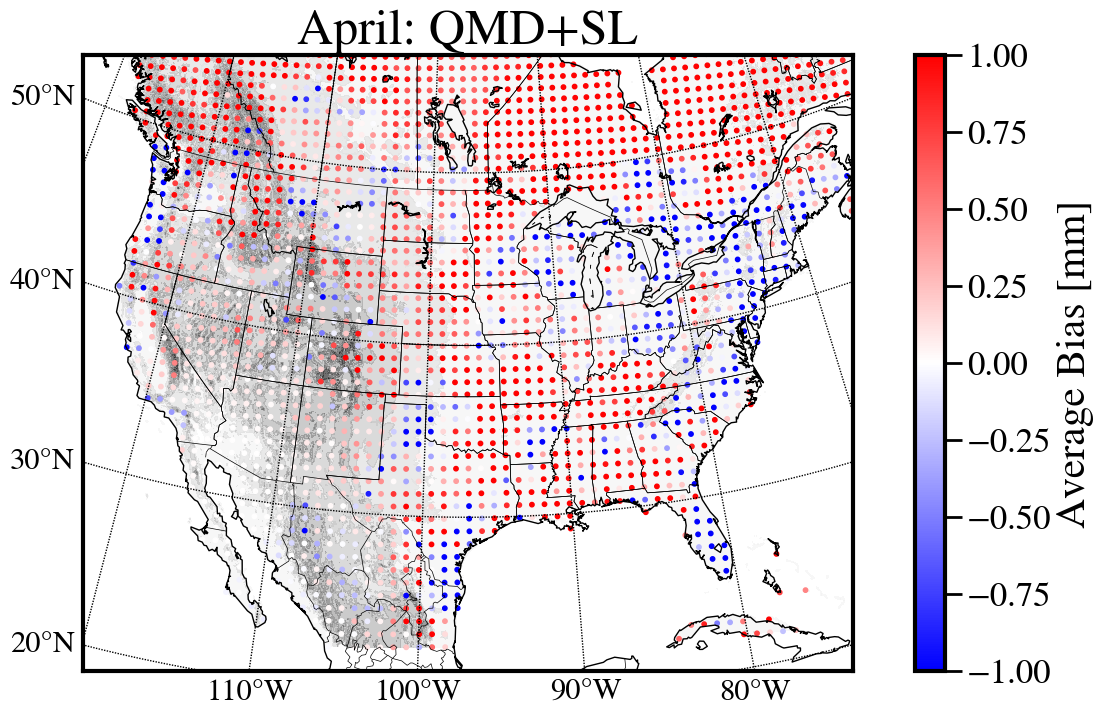

In [31]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
lats, lons = consts.latitude.data, consts.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,terrain_heights,extend='both',ax=axes,cmap='gist_yarg',alpha=0.4)

### plot biases ###
model = 2
month=1 #[1,4,7,11]

dat = models[model].bias.mean(dim='day').mean(dim='member').data.compute()
mn, gp = np.where(np.isfinite(dat) == False)
dat[mn,gp] = np.nan
xgp, ygp = m(lons[lat_idx, lon_idx], lats[lat_idx, lon_idx])
sc=plt.scatter(xgp, ygp, c=dat[month], cmap='bwr', s=10,vmin=-1, vmax=1)
cbar=plt.colorbar(sc, label='Average Bias [mm]')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

axes.set_title(f"{datetime.datetime(2023, months[month], 1).strftime('%B')}: {model_names[model]}")

# MAE, RMSE

In [15]:
dat = climo.bias.sum(dim='day').sum(dim='grid_point').data.compute() / (2260+30)

In [16]:
np.shape(dat)

(4, 30)

Text(138.16666666666669, 0.5, 'MAE')

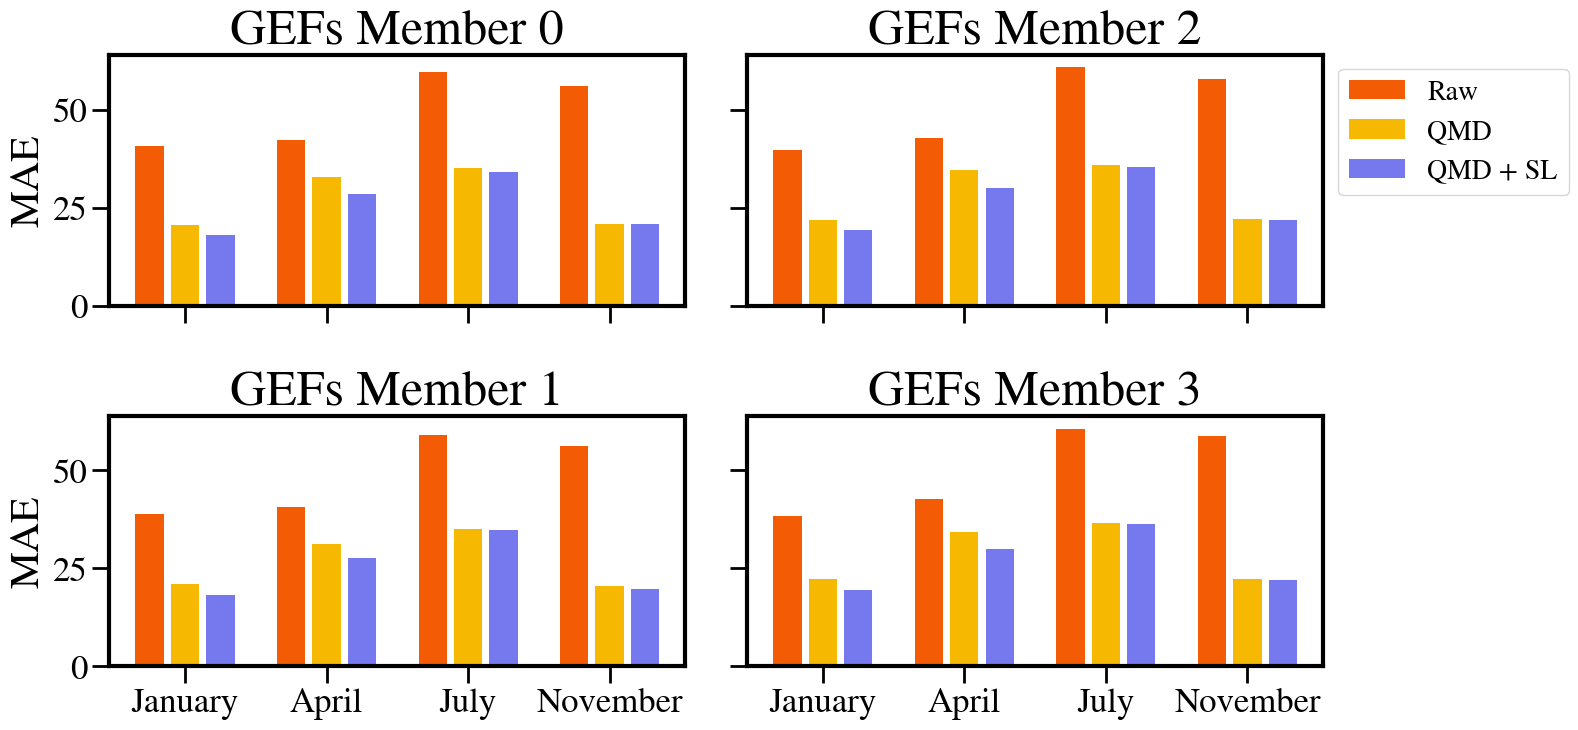

In [29]:
fig, axes = plt.subplots(2,2,sharex=True, sharey=True, figsize=(16,8))
coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']
lss = ['--', '-',  ':']

mn_colors = ['#355070', '#6d597a', '#b56576', '#eaac8b']

#axes[0,0].set_ylim([0., 2.4])

N = 15

for i in range(2):
    for j in range(2):
        mem = i + 2*j
        for model in range(3):
            dat = models[model].bias.sum(dim='grid_point').sum(dim='day').data.compute() / (2260 + 30)
            mn, mm = np.where(np.isfinite(dat) == False)
            dat[mn,mm] = np.nan
            for mn in range(0,4):
                bar_x = mn*4
                if model == 0:
                    axes[i,j].bar(bar_x-1, dat[mn,mem], color=coolors[model], label=('' if (i==0) and (mn==0) else '_')+f"{model_names[model]}")
                elif model == 1:
                    axes[i,j].bar(bar_x, dat[mn,mem], color=coolors[model],label=('' if (i==0) and (mn==0) else '_')+f"{model_names[model]}")
                else:
                    axes[i,j].bar(bar_x+1, dat[mn,mem], color=coolors[model],label=('' if (i==0) and (mn==0) else '_')+f"{model_names[model]}")
        axes[i,j].set_title(f"GEFs Member {mem}")

axes[0,1].legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.tight_layout()
axes[1,0].set_xticks([0, 4, 8, 12])
axes[1,0].set_xticklabels(["January", 'April', 'July', 'November'])

axes[0,0].set_ylabel('MAE')
axes[1,0].set_ylabel('MAE')

# Brier Score

In [4]:
no_sl = xr.open_mfdataset(sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/brier*_without_sl_CONUS_24h.zarr"), key=natsort),
                         combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

f = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/brier*_with_sl_CONUS_24h.zarr"), key=natsort)
optimized = xr.open_mfdataset(f, combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

In [17]:
no_sl.thres

<xarray.Dataset> Size: 3kB
Dimensions:    (month: 4, day: 30, threshold: 3)
Coordinates:
  * day        (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * threshold  (threshold) float64 24B 1.0 5.0 10.0
  * month      (month) int64 32B 1 4 7 11
Data variables:
    brier      (month, day, threshold) float64 3kB dask.array<chunksize=(1, 30, 3), meta=np.ndarray>

In [5]:
models = [no_sl, optimized]
months = [1,4,7,11]
model_names = ['QMD', 'QMD + SL']

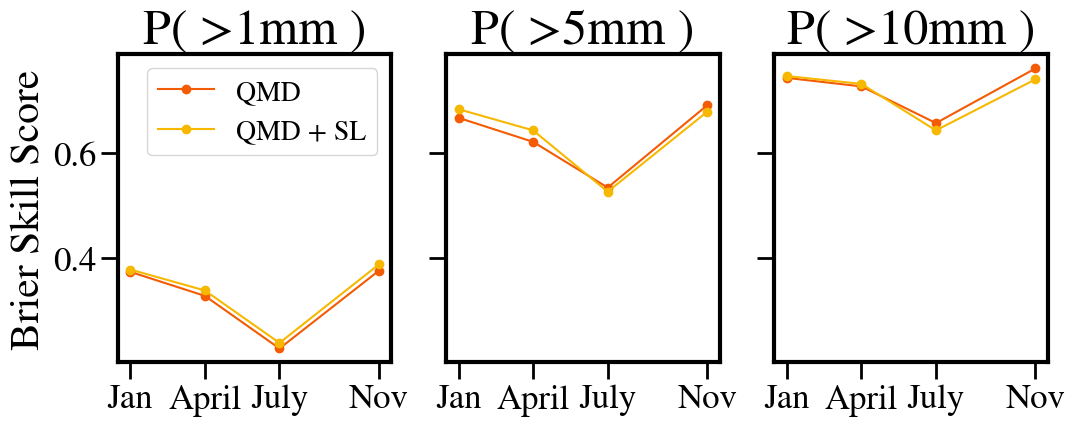

In [35]:
fig, axes = plt.subplots(1,3,sharex=True, sharey=True, figsize=(12,4))
coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']
lss = ['--', '-',  ':']

mn_colors = ['#355070', '#6d597a', '#b56576', '#eaac8b']

#axes[0,0].set_ylim([0., 2.4])
axes[0].set_xticks(months)
axes[0].set_xticklabels(["Jan", 'April', 'July', 'Nov'])

for i in range(3):
    for model in range(2):
        dat = models[model].brier.mean(dim='day').data.compute()
        axes[i].plot(months, dat[:,i], marker='o', color=coolors[model], label=f"{model_names[model]}")
        #axes[i].plot([1,12], [0,0], ls=':', color='black')
    #axes[i].set_xlabel('Month')
    axes[i].set_title(f"P( >{int(no_sl.threshold.data[i])}mm )")

axes[0].set_ylabel('Brier Skill Score')
axes[0].legend()

Text(0.5, 1.0, 'Skill difference\nQMD(SL) - QMD')

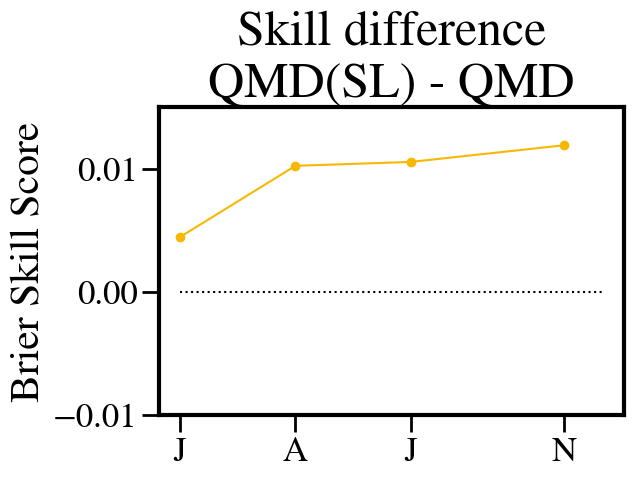

In [23]:
fig, axes = plt.subplots(1,1,sharex=True, sharey=True, figsize=(6,4))
coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']
lss = ['--', '-',  ':']

mn_colors = ['#355070', '#6d597a', '#b56576', '#eaac8b']


axes.set_ylim([-0.01, 0.015])
axes.set_xticks(months)
axes.set_xticklabels(["J", 'A', 'J', 'N'])

for i in [0]:#range(3):
    o = optimized.brier.mean(dim='day').data.compute()[:,i]
    n = no_sl.brier.mean(dim='day').data.compute()[:,i]
    axes.plot(months, o-n, marker='o', color=coolors[1], label=f"QMD+SL - QMD")
    axes.plot([1,12], [0,0], ls=':', color='black')
    #axes[i].set_xlabel('Month')
    #axes[i].set_title(f"P( >{int(no_sl.threshold.data[i])}mm )")

axes.set_ylabel('Brier Skill Score')
axes.set_title("Skill difference\nQMD(SL) - QMD")
#fig.text(0.37, 0.92, "QMD w/SL - QMD")
#axes[0].legend(fontsize=17, frameon=False)

# "Wetter valleys, drier slopes"

There's gotta be a way to verify this is/isn't an issue. Idea: take gradient of terrain height, plot monthly bias as a function

Hypothesis: for gradients near 0, wet(ter) bias than those with steeper gradients.


In [36]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

In [44]:
test_sg_x, test_sg_y = sgolay2d(terrain_heights, 5, 2, derivative='both')
grad = np.sqrt(test_sg_x**2 + test_sg_y**2)

{230.0: ([<matplotlib.lines.Line2D at 0x14bf43aa8a30>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14bf43aa8ca0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14bf43aa8f40>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14bf43aa91e0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14bf43aa9480>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14bf43aa9720>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14bf43aa99c0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14bf43aa9c60>], [])}

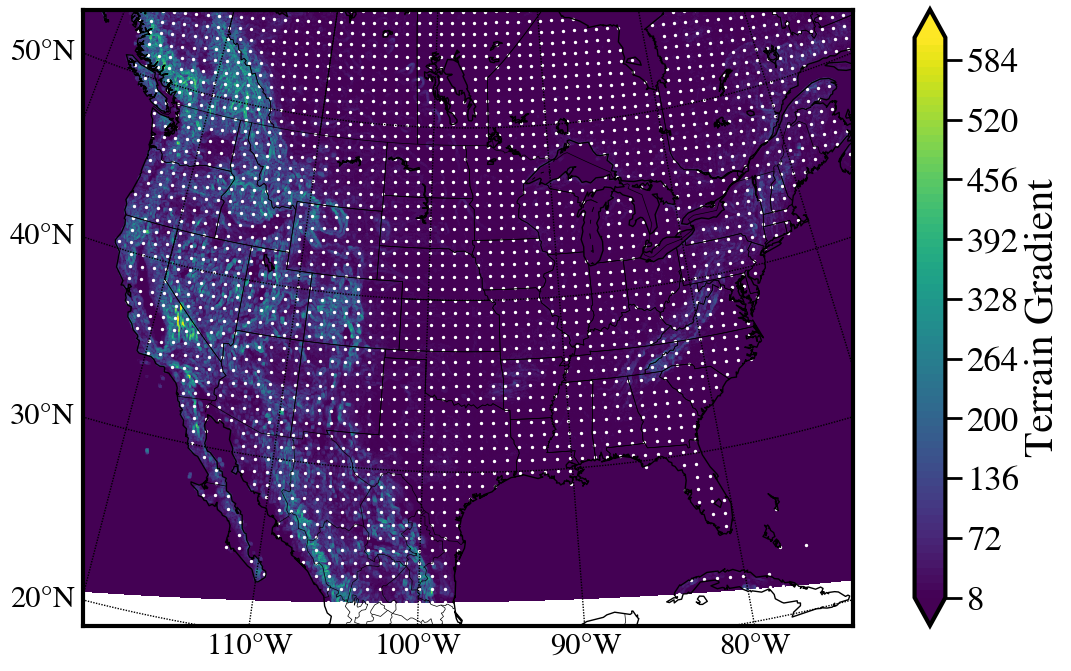

In [106]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
lats, lons = consts.latitude.data, consts.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,grad,extend='both',levels=100,ax=axes,cmap='viridis')
plt.colorbar(cs, label='Terrain Gradient')
xgp, ygp = m(lons[lat_idx, lon_idx], lats[lat_idx, lon_idx])
sc=plt.scatter(xgp, ygp, c='white', s=2)


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [41]:
models = [raw, no_sl, optimized]
months = [1,4,7,11]
model_names = ['Raw', 'QMD', 'QMD + SL']

In [42]:
where_high_terrain = np.where(terrain_heights[lat_idx, lon_idx] > 1000.)

Text(0.5, 0, '$\\log(\\Delta\\mathrm{Terrain})$')

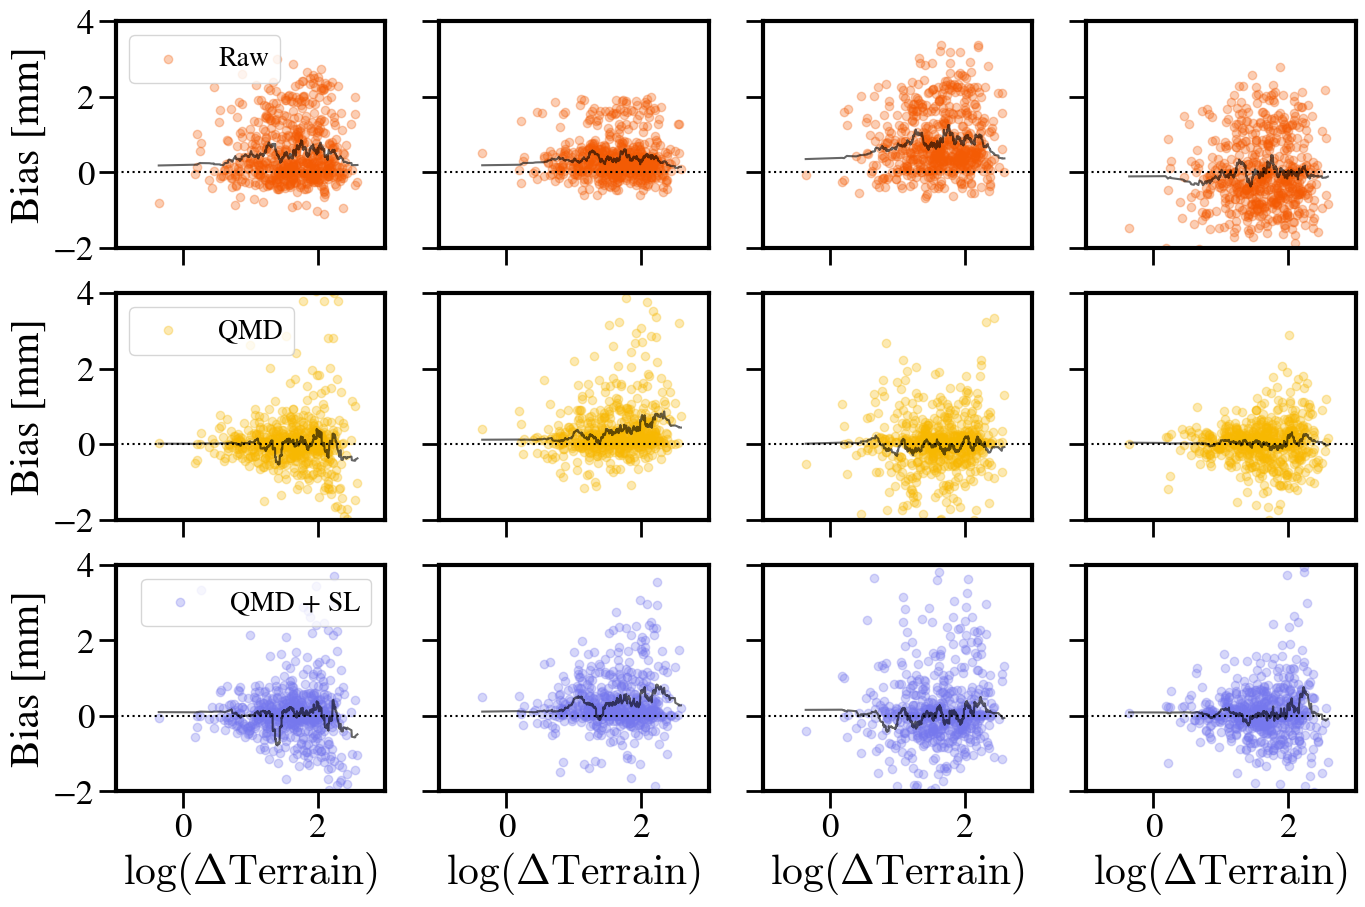

In [45]:
fig, axes = plt.subplots(3,4, sharex=True, sharey=True, figsize=(16, 10))

axes[0,0].set_xlim([-1, 3])
axes[0,0].set_ylim([-2, 4])

N = 40

for mn in range(4):
    for model in range(3):
        axes[model, mn].scatter(np.log10(grad[lat_idx, lon_idx][where_high_terrain]), models[model].bias.mean(dim='day').mean(dim='member').data.compute()[mn][where_high_terrain], 
                                color=coolors[model],alpha=0.3, label=f"{model_names[model]}")
        in_order = np.argsort(np.log10(grad[lat_idx, lon_idx][where_high_terrain]))
        cc = models[model].bias.mean(dim='day').mean(dim='member').data.compute()[mn][where_high_terrain]
        axes[model,mn].plot(np.log10(grad[lat_idx, lon_idx][where_high_terrain])[in_order], np.convolve(cc[in_order], np.ones(N)/N, mode='same'), color='black', alpha=0.6)
        axes[model,mn].plot([-1,3], [0,0], color='black', ls=':')
        axes[model,0].legend()

axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')
axes[2,0].set_ylabel('Bias [mm]')

axes[2,0].set_xlabel('$\log(\Delta\mathrm{Terrain})$')
axes[2,1].set_xlabel('$\log(\Delta\mathrm{Terrain})$')
axes[2,3].set_xlabel('$\log(\Delta\mathrm{Terrain})$')
axes[2,2].set_xlabel('$\log(\Delta\mathrm{Terrain})$')


In [9]:
@jit
def calculate_local_terrain_std(terrain_height, landmask, minseparation):
    terrain_mean = np.zeros_like(terrain_height)
    terrain_stddev = np.zeros_like(terrain_height)
    ny, nx = np.shape(landmask)
    for j in range(nx):
        for i in range(ny):
            # Compute local domain using minseparation
            ### i = lat
            ### j = lon
            imin=max([0,i-minseparation])
            imax=min([ny,i+minseparation])
            jmin=max([0,j-minseparation])
            jmax=min([nx,j+minseparation])
            
            nsamps=0
            sum_terrain=0.0
            sum_terrain2=0.0
            #Local domain
            for jj in range(jmin,jmax):
                for ii in range(imin,imax):
                    dist=np.sqrt((np.float32(i-ii)**2.0)+(np.float32(j-jj)**2.0))
                    if dist > minseparation:
                        continue
                    elif (landmask[i,j] == 0) and (landmask[ii,jj] == 1):
                        continue
                    else:
                        sum_terrain += terrain[ii,jj]
                        sum_terrain2 += terrain[ii,jj]**2.0
                        nsamps += 1
            terrain_mean[i,j]=sum_terrain/nsamps
            terrain_stddev[i,j]=np.sqrt((sum_terrain2-(nsamps*terrain_mean[i,j]**2.0))/(nsamps-1))

    return terrain_mean, terrain_stddev

In [10]:
conus_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc')
lat_idx = conus_sample.latitude_idx.data
lon_idx = conus_sample.longitude_idx.data

consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')
lat_arr = consts.latitude.data
lon_arr =  consts.longitude.data

In [11]:
landmask = consts.landmask.data
terrain = consts.terrain.data

In [12]:
terrain_mean, terrain_std = calculate_local_terrain_std(terrain, landmask, 40.)

In [13]:
tg = terrain_std[lat_idx, lon_idx]

In [12]:
optimized


<xarray.Dataset> Size: 65MB
Dimensions:     (month: 4, day: 30, grid_point: 2260, member: 30)
Coordinates:
  * day         (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * grid_point  (grid_point) int64 18kB 0 1 2 3 4 5 ... 2255 2256 2257 2258 2259
  * member      (member) int64 240B 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28 29
  * month       (month) int64 32B 1 4 7 11
Data variables:
    bias        (month, day, grid_point, member) float64 65MB dask.array<chunksize=(1, 8, 565, 15), meta=np.ndarray>

In [22]:
np.shape(tg)

(2260,)

In [18]:
mb

dask.array<mean_agg-aggregate, shape=(4, 2260), dtype=float64, chunksize=(1, 565), chunktype=numpy.ndarray>

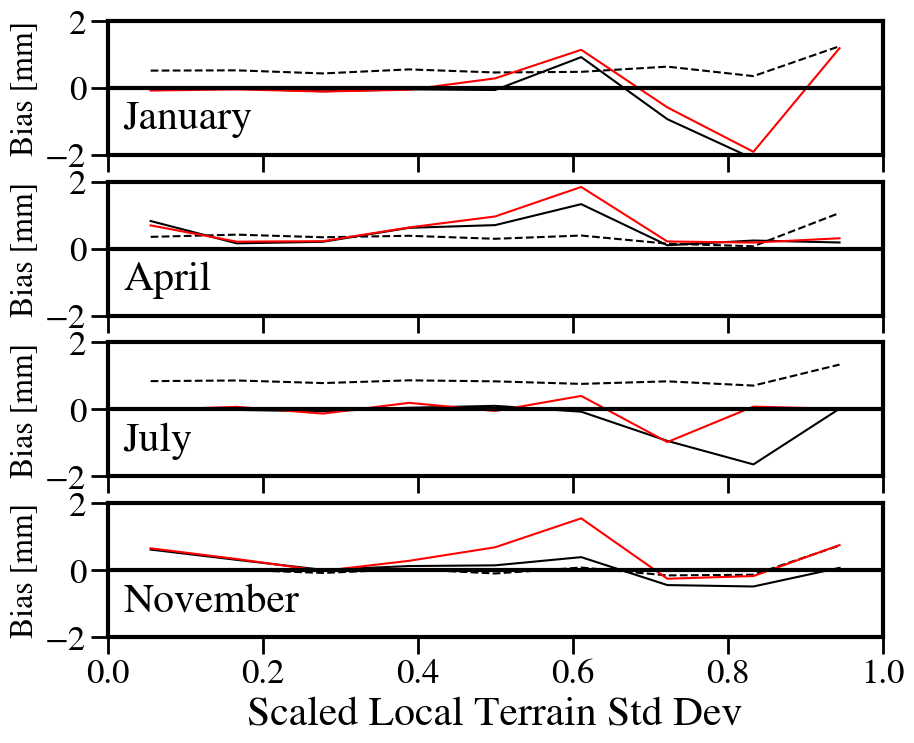

In [81]:
fig, axes = plt.subplots(4, sharex=True,sharey=True, figsize=(10, 8))

coolors = ['#f35b04', '#f7b801', '#7678ed', '#3d348b']

axes[0].set_xlim([0, 1])
axes[3].set_xlabel('Scaled Local Terrain Std Dev')
axes[0].set_ylim([-2,2])

for mn in range(4): #months
    for mo in range(3): #models
        this_mod = models[mo].bias.mean(dim='member').data.compute()
        mb = np.where(this_mod == np.inf, np.nan, this_mod)
        mb = np.nanmean(mb, axis=1)
        #print(np.shape(mb))
        #print(np.shape(tg))
        bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(tg/np.max(tg), mb[mn], statistic=np.nanmean, bins=np.linspace(0,1,10))
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        if mo == 0:
            rr, = axes[mn].plot(bin_centers, bin_means,color='black', ls='--', label=m_names[mo])
        elif mo == 1:
            nsl, = axes[mn].plot(bin_centers, bin_means,color='black', label=m_names[mo])
            #bin_stds, b_, _ = stats.binned_statistic(terrain_height[lat_idx,lon_idx][gps_where_nonzero], model_bias[m], statistic=np.nanstd, bins=np.linspace(0,2000,100))
            #plt.fill_between(bin_centers, bin_means+bin_stds, bin_means-bin_stds,color='black', alpha=0.3)
        else:
            tt, = axes[mn].plot(bin_centers, bin_means, color='r',  label=m_names[mo])

    axes[mn].plot([0,1], [0,0], color='black', lw=3)
    axes[mn].set_ylabel('Bias [mm]', fontsize=23)
    axes[mn].text(.02,.13, f"{datetime.datetime(2023, months[mn], 4).strftime('%B')}", ha='left', va='bottom', transform=axes[mn].transAxes)

#axes[0].legend(handles=[rr, nsl, tt], labels=model_names,bbox_to_anchor=(1., 0.3))

    
#plt.ylabel('Bias [mm]')
#plt.xlabel('Terrain Height [m]')
#plt.legend(frameon=False, ncol=3, fontsize=16, loc='upper left')
#plt.xlim([-1,2000])
#plt.ylim([-1, 1])
#plt.text(.98,.13, f"{datetime.datetime(2023, months[month], 4).strftime('%B')}", ha='right', va='bottom', transform=ax.transAxes)
#plt.text(.98, .87, f"URMA APCP > 0.254mm",fontsize=15, ha='right', va='top', transform=ax.transAxes)

Text(0.6, 7, 'Terrain Std Dev')

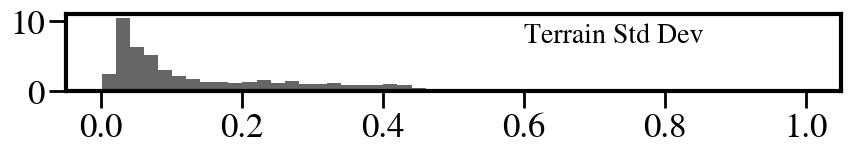

In [110]:
fig, ax = plt.subplots(1,1, figsize=(10,1))
plt.hist(tg/np.max(tg),bins=50, color='black', alpha=0.6, density=True)
plt.annotate('Terrain Std Dev', xy=(0.6, 7), fontsize=20)

In [34]:
np.shape(mb)

(4, 2260)

In [37]:
mb[2][628].compute() == np.inf

True

In [42]:
tg

array([671.32715, 761.01685, 450.3209 , ..., 131.8299 , 146.32306,
       157.1744 ], dtype=float32)

In [43]:
np.where(np.isfinite(tg) == False)

(array([], dtype=int64),)

In [44]:
2260 / 10

226.0